# IBS (Internal Bar Strength Indicator) Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### IBS process
* IBS = (close - low) / (high - low)
* This is a kind of mean-reversion indicator, which denotes trend-reversal.
* IBS itself reflects a candle that no up-tail positive candle when IBS=1 and no bottom-tail negative candle when IBS=0.
* If IBS goes under the buy limit (0.2) then buy, and else goes higher than the sell limit (0.8) then sell.
* Since this makes too many signals, I did apply some conditions where sell-price should be larger than last-buy-price by a least rate or stop-loss under a worst rate.

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [52]:
def IBS_Signal(pr_df, buy=0.2, sell=0.8, least=0.02, worst=0.15):
    pr = pr_df.copy()
    pr['IBS'] = (pr['close'] - pr['low']) / (pr['high'] - pr['low'])
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    last_buy_price=0
    for i in range(1,len(pr)):
        if pr['IBS'][i-1] < buy and flag != 1:
            Buy.append(pr['open'][i])
            last_buy_price=pr['open'][i]
            #Sell.append(pr['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif pr['IBS'][i-1] > sell and flag != 0 and pr['close'][i]/last_buy_price >= 1+least or pr['close'][i]/last_buy_price <= 1-worst:
            Buy.append(np.nan)
            Sell.append(pr['close'][i])
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    pr['BuySignal'] = Buy
    pr['SellSignal'] = Sell
    firstSell = pr[pr['SellSignal'].notnull()].index[0]
    firstBuy = pr[pr['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        pr.loc[firstSell,'SellSignal'] = np.nan
    return pr

In [9]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [20]:
def IBS_Run(start, end, code, buy=0.2, sell=0.8, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code])
    pr = pr.rename(columns={'adjprice':'close','OPEN':'open'})
    pr.index = pr['DATE'].to_list()
    pr = pr.drop(['DATE','CODE'],axis=1)
    ibs = IBS_Signal(pr,buy=buy, sell=sell)
    
    if doplot :
        plt.style.use('fivethirtyeight')
        ibs[['IBS']].plot(figsize=(10,6))
        plt.title("IBS for {}".format(code))
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(ibs.index, ibs['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(ibs.index, ibs['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(ibs['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('IBS on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(ibs)
    rst.index = [code]

    return rst

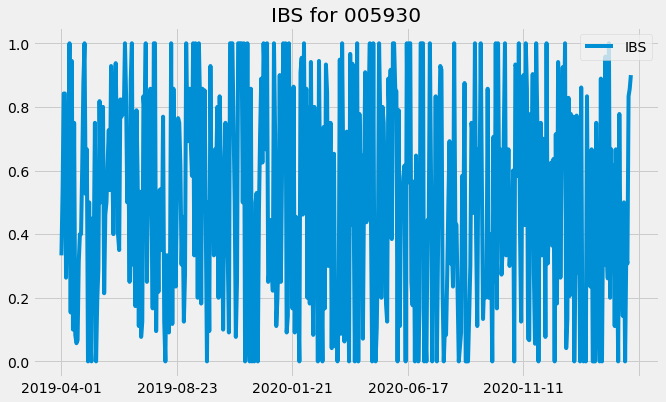

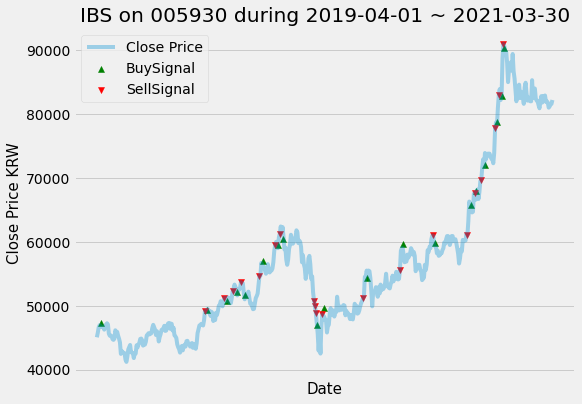

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.59,0.85,0.1,-0.16,0.32,1.02,1.02,20,0.42


In [53]:
IBS_Run('2019-04-01','2021-03-30','005930',0.3, 0.7, True)

In [54]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-30'
for cd in ['005930','005935','034220','066570','950180']:
    total = pd.concat([total,IBS_Run(start,end,cd,0.2,0.8,False)])

Wall time: 8.03 s


In [55]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.81,0.86,0.1,-0.16,0.32,1.03,1.03,21,0.87
005935,2.1,0.88,0.09,-0.17,0.33,1.03,1.03,26,1.08
034220,1.3,0.74,0.17,-0.19,0.6,1.02,1.01,23,-0.19
066570,1.77,0.78,0.24,-0.16,0.24,1.03,1.02,27,0.32
950180,0.81,0.53,0.46,-0.28,0.69,1,1,60,-1.00


# Conclusion
* It makes many signals in a short period.
* But reversals seem bad for catching a alpha...
* In terms of short term signals, trend-momentum works better.

---